Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


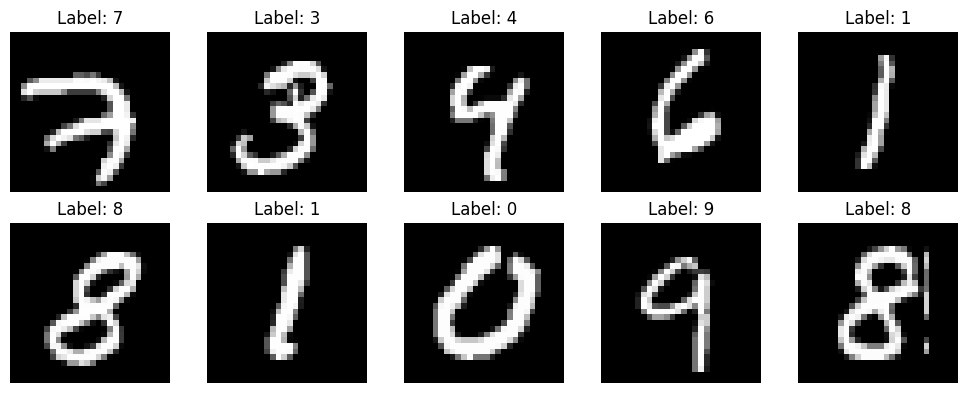

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
import mnist

# Загрузка данных MNIST
train, val, test = mnist.load_mnist()
train_images, train_labels = train
val_images, val_labels = val
test_images, test_labels = test

# Преобразование изображений в векторы (28x28 -> 784)
train_images = train_images.reshape(train_images.shape[0], -1)
val_images = val_images.reshape(val_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

# Визуализация примеров изображений
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {train_labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.savefig('mnist_samples.png')
plt.show()

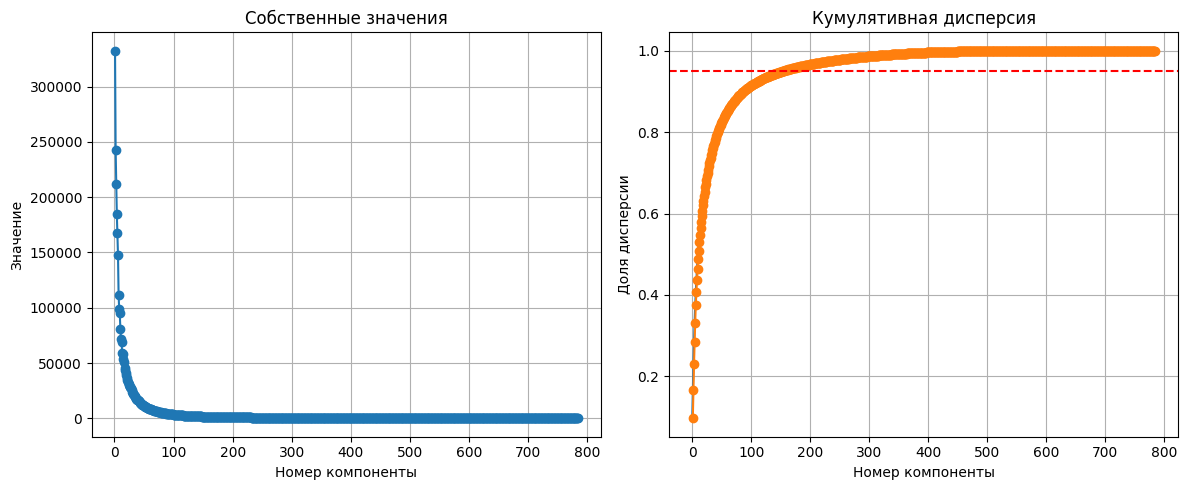

Доля дисперсии первых 15 компонент: 0.5791


In [7]:
# Реализация класса my_PCA
class my_PCA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.mean_ = None
        self.components_ = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None

    def fit(self, X):
        # Центрирование данных
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_

        # Вычисление SVD
        U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

        # Сохранение компонент
        if self.n_components is None:
            self.components_ = Vt
        else:
            self.components_ = Vt[:self.n_components]

        # Вычисление собственных значений и их долей
        n = X.shape[0]
        self.explained_variance_ = S ** 2 / (n - 1)
        self.explained_variance_ratio_ = self.explained_variance_ / np.sum(self.explained_variance_)

    def transform(self, X):
        X_centered = X - self.mean_
        return X_centered @ self.components_.T

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


# Реализация класса my_kNN
class my_kNN:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = []
        for x in X:
            # Вычисление евклидовых расстояний
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            # Нахождение k ближайших соседей
            k_indices = np.argsort(distances)[:self.n_neighbors]
            # Получение меток соседей
            k_nearest_labels = self.y_train[k_indices]
            # Определение наиболее частой метки
            counts = np.bincount(k_nearest_labels)
            predicted_label = np.argmax(counts)
            predictions.append(predicted_label)
        return np.array(predictions)


# Анализ PCA
pca = my_PCA(n_components=784)
pca.fit(train_images)

# График собственных значений и кумулятивной дисперсии
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
toch = pca.explained_variance_
plt.plot(np.arange(1, len(toch)+1), eigs, marker='o')
plt.title('Собственные значения')
plt.xlabel('Номер компоненты')
plt.ylabel('Значение')
plt.grid(True)

plt.subplot(1, 2, 2)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance)
plt.plot(np.arange(1, len(toch)+1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title('Кумулятивная дисперсия')
plt.xlabel('Номер компоненты')
plt.ylabel('Доля дисперсии')
plt.grid(True)
plt.tight_layout()
plt.savefig('pca_variance.png')
plt.show()

# Доля дисперсии первых 15 компонент
print(f"Доля дисперсии первых 15 компонент: {np.sum(pca.explained_variance_ratio_[:15]):.4f}")

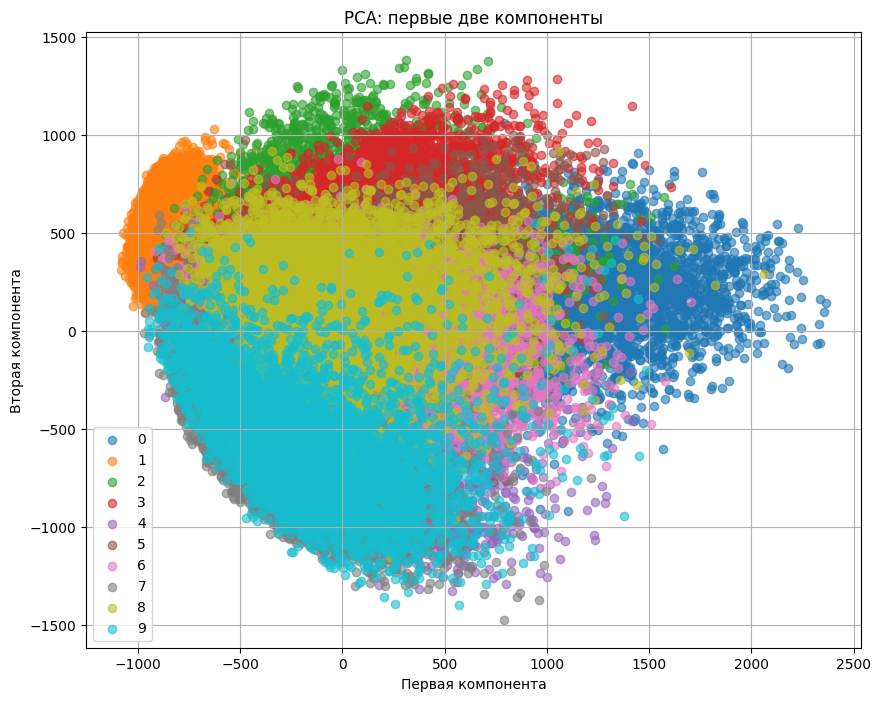

In [3]:
# Визуализация первых двух компонент
X_pca = pca.transform(train_images)[:, :2]
plt.figure(figsize=(10, 8))
for i in range(10):
    idx = np.where(train_labels == i)[0]
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=str(i), alpha=0.6)
plt.legend()
plt.title('PCA: первые две компоненты')
plt.xlabel('Первая компонента')
plt.ylabel('Вторая компонента')
plt.grid(True)
plt.savefig('pca_2d.png')
plt.show()

Точность kNN без PCA: 0.2676
Точность kNN с PCA (64 компоненты): 0.9747
Точность kNN с PCA (16 компоненты): 0.9628


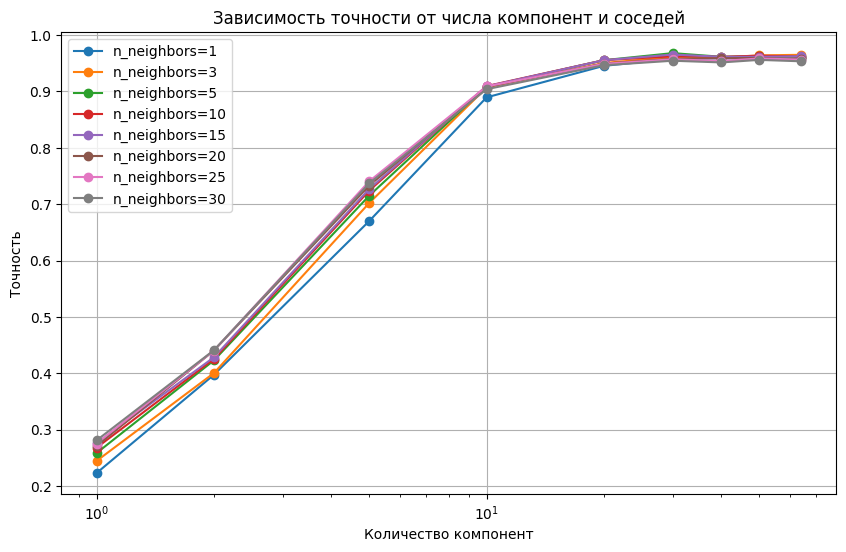

In [4]:
# Применение kNN без PCA
knn = my_kNN(n_neighbors=5)
knn.fit(train_images, train_labels)
preds = knn.predict(test_images)
acc = accuracy_score(test_labels, preds)
print(f"Точность kNN без PCA: {acc:.4f}")

# Применение kNN с PCA (64 компоненты)
pca_64 = my_PCA(n_components=64)
X_train_pca_64 = pca_64.fit_transform(train_images)
X_test_pca_64 = pca_64.transform(test_images)

knn_pca_64 = my_kNN(n_neighbors=5)
knn_pca_64.fit(X_train_pca_64, train_labels)
preds_pca_64 = knn_pca_64.predict(X_test_pca_64)
acc_pca_64 = accuracy_score(test_labels, preds_pca_64)
print(f"Точность kNN с PCA (64 компоненты): {acc_pca_64:.4f}")

# Пример с 16 компонентами
pca_16 = my_PCA(n_components=16)
X_train_pca_16 = pca_16.fit_transform(train_images)
X_test_pca_16 = pca_16.transform(test_images)

knn_pca_16 = my_kNN(n_neighbors=5)
knn_pca_16.fit(X_train_pca_16, train_labels)
preds_pca_16 = knn_pca_16.predict(X_test_pca_16)
acc_pca_16 = accuracy_score(test_labels, preds_pca_16)
print(f"Точность kNN с PCA (16 компоненты): {acc_pca_16:.4f}")

# Исследование зависимости точности от числа компонент и соседей
components = [1, 2, 5, 10, 20, 30, 40, 50, 64]
neighbors = [1, 3, 5, 7, 10, 15, 20, 25, 30]

# для ускорения поиска
test_subset_size = 2000
X_test_subset_full = test_images[:test_subset_size]
y_test_subset_full = test_labels[:test_subset_size]

accuracy_matrix = np.zeros((len(components), len(neighbors)))

for i, n_comp in enumerate(components):
    pca = my_PCA(n_components=n_comp)
    X_train_pca = pca.fit_transform(train_images)
    X_test_pca_subset = pca.transform(X_test_subset_full)  # ← только 2000 изображений
    for j, n_neigh in enumerate(neighbors):
        knn = my_kNN(n_neighbors=n_neigh)
        knn.fit(X_train_pca, train_labels)
        preds = knn.predict(X_test_pca_subset)  # ← предсказание только на 2000 изображениях
        acc = accuracy_score(y_test_subset_full, preds)
        accuracy_matrix[i, j] = acc

# График зависимости точности от числа компонент при разных соседях
plt.figure(figsize=(10, 6))
for j, n_neigh in enumerate([1, 3, 5, 10, 15, 20, 25, 30]):
    plt.plot(components, accuracy_matrix[:, j], marker='o', label=f'n_neighbors={n_neigh}')
plt.xlabel('Количество компонент')
plt.ylabel('Точность')
plt.title('Зависимость точности от числа компонент и соседей')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.savefig('pca_knn_comparison.png')
plt.show()

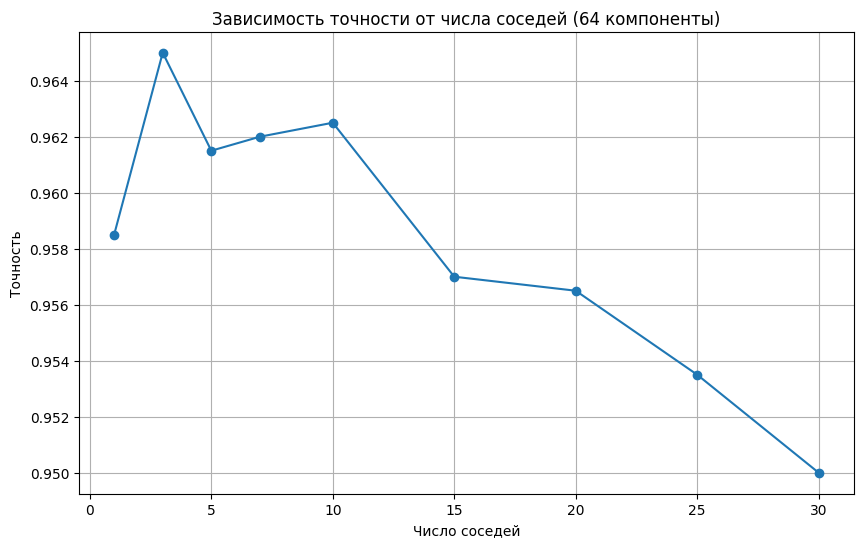

Лучшая точность: 0.9680 при компонентах=30, соседей=5


In [5]:
# График зависимости точности от числа соседей при фиксированном числе компонент (64)
best_comp_index = components.index(64)
plt.figure(figsize=(10, 6))
plt.plot(neighbors, accuracy_matrix[best_comp_index, :], marker='o')
plt.xlabel('Число соседей')
plt.ylabel('Точность')
plt.title('Зависимость точности от числа соседей (64 компоненты)')
plt.grid(True)
plt.savefig('knn_neighbors.png')
plt.show()

# Нахождение оптимальных параметров
best_acc = np.max(accuracy_matrix)
i_max, j_max = np.unravel_index(np.argmax(accuracy_matrix), accuracy_matrix.shape)
best_comp = components[i_max]
best_neigh = neighbors[j_max]
print(f"Лучшая точность: {best_acc:.4f} при компонентах={best_comp}, соседей={best_neigh}")
